In [11]:
import numpy as np
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

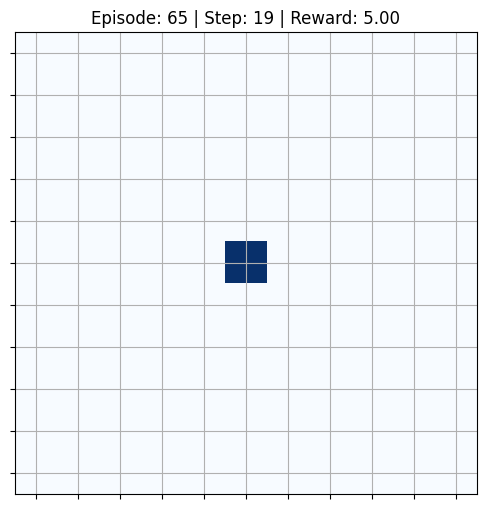

KeyboardInterrupt: 

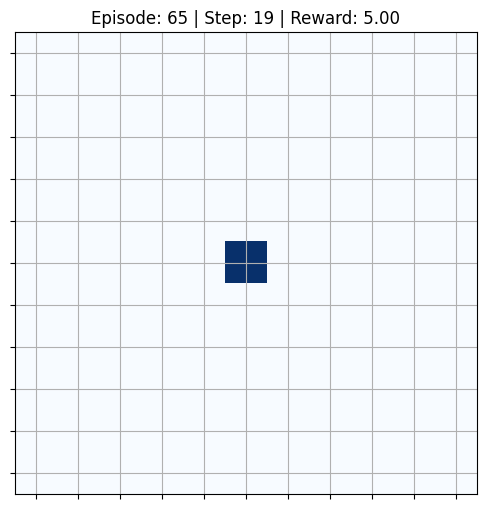

In [19]:
class StayStillEnv(gym.Env):
    def __init__(self):
        super(StayStillEnv, self).__init__()
        self.grid_size = 11
        self.action_space = spaces.Discrete(5)  # [stay, up, down, left, right]
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.int32)
        self.reset()
        
        # UI Setup
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.img = None
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.ax.set_xticks(np.arange(self.grid_size))
        self.ax.set_yticks(np.arange(self.grid_size))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True)

    def reset(self):
        self.agent_pos = np.array([5, 5])  # start at center
        self.steps = 0
        self.episode_count = 0
        self.reward = 0
        self.done = False
        return self.agent_pos

    def step(self, action):
        x, y = self.agent_pos

        # Move based on action
        if action == 1 and y > 0:      # up
            y -= 1
        elif action == 2 and y < 10:   # down
            y += 1
        elif action == 3 and x > 0:    # left
            x -= 1
        elif action == 4 and x < 10:   # right
            x += 1
        # action == 0 means stay still

        self.agent_pos = np.array([x, y])
        reward = self.calculate_reward(action)

        self.steps += 1
        self.reward = reward
        
        if self.steps >= 50:  # Maximum number of steps in each episode
            self.done = True
        return self.agent_pos, reward, self.done, {}

    def calculate_reward(self, action):
        x, y = self.agent_pos
        # Preferred zone: center 3x3
        if 4 <= x <= 6 and 4 <= y <= 6:
            if action == 0:
                if (x, y) == (5, 5):
                    return 5.0
                return 1.0  # reward for staying still
            else:
                return -0.1  # small penalty for moving

        # Medium penalty zone: between outer and inner square
        elif 2 <= x <= 9 and 2 <= y <= 9:
            return -1.0

        # Outside penalty zone
        else:
            return -10.0
        
    def set_episode(self, episode_number):
        self.episode_count = episode_number

    def render(self):
        self.grid = np.zeros((self.grid_size, self.grid_size))
        x, y = self.agent_pos
        self.grid[y, x] = 1  # Mark the agent's position
        
        # Plot the grid
        if self.img is None:
            self.img = self.ax.imshow(self.grid, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
        else:
            self.img.set_data(self.grid)

        # Display additional information
        self.ax.set_title(f'Episode: {self.episode_count} | Step: {self.steps} | Reward: {self.reward:.2f}')
        
        # Use IPython display for real-time updates
        clear_output(wait=True)
        display(self.fig)
        
    def close(self):
        plt.show()


# Define the Q-Network (Deep Q-Network)
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env, device):
        self.env = env
        self.device = device
        self.action_space = env.action_space
        self.state_space = env.observation_space
        self.memory = deque(maxlen=2000)  # Experience replay
        self.batch_size = 64
        self.gamma = 0.99  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.target_update_freq = 10

        self.model = QNetwork(2, 5).to(self.device)  # 2 inputs (x, y) and 5 possible actions
        self.target_model = QNetwork(2, 5).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.episode_count = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.action_space.sample()  # Random action (exploration)
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()  # Greedy action (exploitation)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(self.device)

            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state)).item()

            q_values = self.model(state)
            q_values[0][action] = target

            self.optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(q_values, self.model(state))
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


# Training Loop
def train_dqn(episodes=1000):
    env = StayStillEnv()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DQNAgent(env, device)
    for episode in range(episodes):
        print(f"Episode {episode+1} Started")
        state = env.reset()
        env.set_episode(episode + 1)  # Update episode in the env
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            state = next_state
            total_reward += reward
            env.render()  # Render after each step to update the UI
        agent.update_target_model()
        agent.episode_count = agent.episode_count + 1
        print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
    env.close()

# Start training the DQN agent
train_dqn(episodes=100)


Adding Prioritized Replay Buffer 

KeyboardInterrupt: 

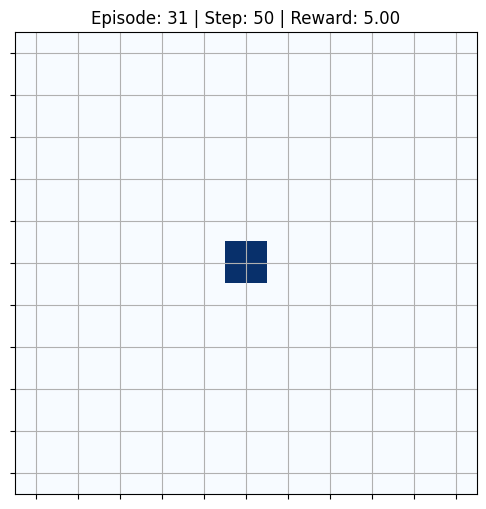

In [20]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.optim as optim
import random
import heapq
from collections import namedtuple, deque

# -----------------------
# Custom Gym Environment
# -----------------------
class StayStillEnv(gym.Env):
    def __init__(self):
        super(StayStillEnv, self).__init__()
        self.grid_size = 11
        self.action_space = spaces.Discrete(5)  # [stay, up, down, left, right]
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.int32)
        self.reset()
        
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.img = None
        self.grid = np.zeros((self.grid_size, self.grid_size))
        self.ax.set_xticks(np.arange(self.grid_size))
        self.ax.set_yticks(np.arange(self.grid_size))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True)

    def reset(self):
        self.agent_pos = np.array([5, 5])
        self.steps = 0
        self.episode_count = 0
        self.reward = 0
        self.done = False
        return self.agent_pos.astype(np.float32)

    def step(self, action):
        x, y = self.agent_pos

        if action == 1 and y > 0:
            y -= 1
        elif action == 2 and y < 10:
            y += 1
        elif action == 3 and x > 0:
            x -= 1
        elif action == 4 and x < 10:
            x += 1

        self.agent_pos = np.array([x, y])
        reward = self.calculate_reward(action)

        self.steps += 1
        self.reward = reward
        if self.steps >= 50:
            self.done = True
        return self.agent_pos.astype(np.float32), reward, self.done, {}

    def calculate_reward(self, action):
        x, y = self.agent_pos
        if 4 <= x <= 6 and 4 <= y <= 6:
            if action == 0:
                return 5.0 if (x, y) == (5, 5) else 1.0
            return -0.1
        elif 2 <= x <= 9 and 2 <= y <= 9:
            return -1.0
        else:
            return -10.0

    def set_episode(self, episode_number):
        self.episode_count = episode_number

    def render(self):
        self.grid = np.zeros((self.grid_size, self.grid_size))
        x, y = self.agent_pos
        self.grid[y, x] = 1
        
        if self.img is None:
            self.img = self.ax.imshow(self.grid, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)
        else:
            self.img.set_data(self.grid)

        self.ax.set_title(f'Episode: {self.episode_count} | Step: {self.steps} | Reward: {self.reward:.2f}')
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        plt.show()


# --------------------------
# Prioritized Replay Buffer
# --------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha
        self.epsilon = 1e-4

    def push(self, transition):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.buffer)]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)


# ---------------------
# Deep Q-Network Model
# ---------------------
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


# ---------------------
# DQN Agent
# ---------------------
class DQNAgent:
    def __init__(self, state_size, action_size, device, buffer, batch_size=64, gamma=0.99, lr=1e-3,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        self.buffer = buffer
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0

        self.policy_net = QNetwork(state_size, action_size).to(device)
        self.target_net = QNetwork(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def memorize(self, state, action, reward, next_state, done):
        self.buffer.push((state, action, reward, next_state, done))

    def learn(self, beta=0.4):
        if len(self.buffer) < self.batch_size:
            return

        transitions, idxs, is_weights = self.buffer.sample(self.batch_size, beta)
        states, actions, rewards, next_states, dones = zip(*transitions)

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)
        is_weights = torch.tensor(is_weights, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * max_next_q

        td_error = target_q - q_values
        loss = (is_weights * td_error.pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        new_priorities = td_error.detach().abs().cpu().numpy() + self.buffer.epsilon
        self.buffer.update_priorities(idxs, new_priorities)

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        self.steps_done += 1
        if self.steps_done % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


# ---------------------
# Training Loop
# ---------------------
def train_dqn(episodes=100):
    env = StayStillEnv()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buffer = PrioritizedReplayBuffer(10000)
    agent = DQNAgent(state_size=2, action_size=env.action_space.n, device=device, buffer=buffer)

    for episode in range(episodes):
        state = env.reset()
        env.set_episode(episode + 1)
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.memorize(state, action, reward, next_state, done)
            agent.learn()
            state = next_state
            total_reward += reward
            env.render()

        print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

    env.close()


# Run training
train_dqn(episodes=100)
